In [1]:
import os
root = os.path.join('..')
data_root = os.path.join(root, 'data')
dataset_root = os.path.join(root, '..', 'datasets')
fig_root = os.path.join(root, 'figs')

In [2]:
import sys
sys.path.append(root)

In [3]:
from typing import Any, Dict, Tuple, Type, Union

import torch

from utils.fig import Axes, Figure
from utils.interfaces import ResultsRealAlongLrs, ResultsSyntheticAlongLrs

In [4]:
Figure.set_seaborn_theme()
Figure.set_tex()
Figure.set_high_dpi()

In [5]:
def embed_graph(
    ax: Axes,
    result_class: Type[Union[ResultsSyntheticAlongLrs, ResultsRealAlongLrs]],
    orig_kwargs: Dict[str, Any], 
    keys: Tuple[str, ...],
    x2d: Tuple[Tuple[float, ...], ...], 
    xlabel: str,
    show_agreement: bool = True,
) -> None:
    assert len(keys) == len(x2d)
    n = len(x2d[0])
    for x1d in x2d[1:]:
        assert len(x1d) == n
    
    accs = []
    adv_accs_for_natural = []
    agreements_for_rand = []
    for i in range(n):
        kwargs = orig_kwargs.copy()
        for j, key in enumerate(keys):
            kwargs[key] = x2d[j][i]
        kwargs.update({'data_root': data_root, 'device': torch.device('cpu')})
        r = result_class(**kwargs)
        accs.append(r.acc)
        adv_accs_for_natural.append(r.adv_acc_for_natural)
        agreements_for_rand.append(r.agreement)

    xticks = x2d[0]
    ax.line(xticks, accs, label='Standard', marker='o')
    ax.line(xticks, adv_accs_for_natural, label='Perturbation', marker='X', linestyle='--')
    if show_agreement:
        ax.line(xticks, agreements_for_rand, label='Agreement', marker='^', linestyle=':')
    ax.set_xticks(xticks)
    ax.set_yticks([.5, .75, 1.])
    ax.set_ylim(.4, 1.05)
    ax.set_xlabel(xlabel)
    

def begin(n_row: int, show_supylabel: bool = True) -> Figure:
    Figure.set_font_scale(.85)
    f = Figure(n_row, 2, (6, 1.5*n_row))
    if show_supylabel:
        f.set_supylabel('Accuracy (blue and orange) / Agreement (green)')
    return f


def end(f: Figure, fname: str) -> None:
    f.save(fig_root, f'{fname}.pdf')
    f.show()
    f.close()

# Synthetic

## Shifted Gaussian

### Scenario (a)

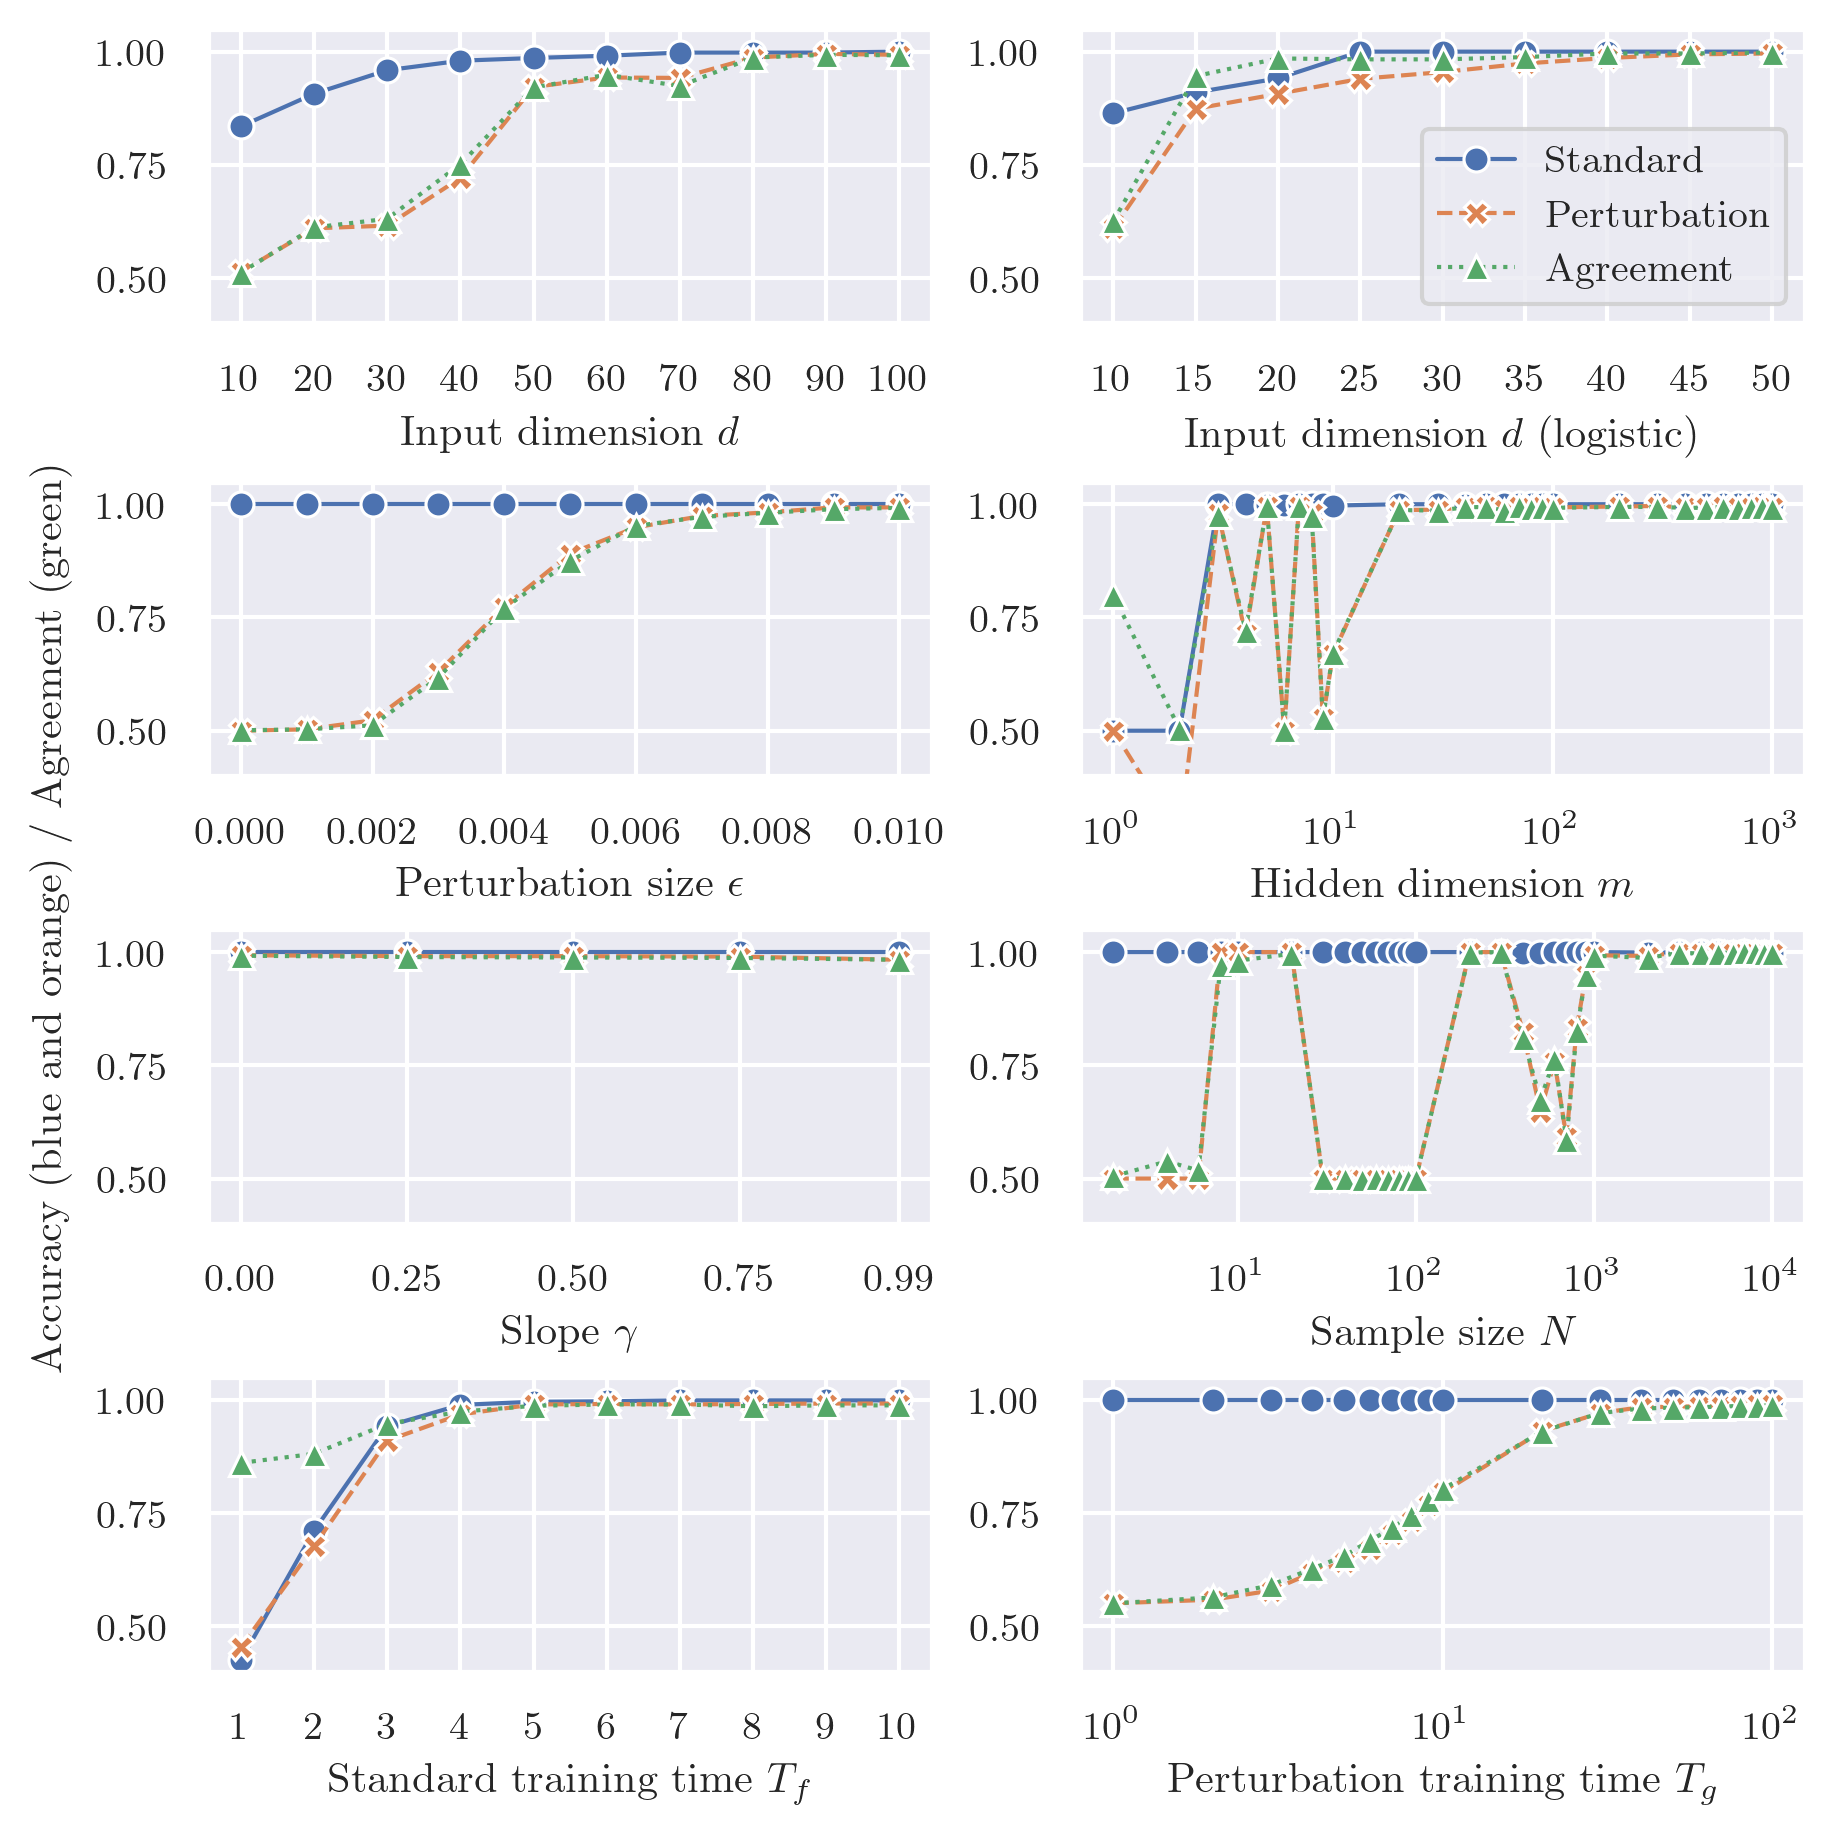

In [6]:
def sG_a() -> None:
    f = begin(4)

    kwargs = {
        'in_dim': 100,
        'hidden_dim': 100,
        'slope': 0.,
        'loss_name': 'identity',
        'epochs_1': 1000,
        'epochs_2': 1000,
        'perturbation_size': .01,
        'seed': 0,
        'on_original': False,
        'lrs_1': (1., .1),
        'lrs_2': (1., .1),
        'data_gen_method': 'shifted_gauss',
        'n_sample': 1000,
    }

    result_class = ResultsSyntheticAlongLrs

    in_dims = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    perturbation_sizes = (.0031, .0044, .0054, .0063, .007, .0077, .0083, .0089, .0094, .01)
    embed_graph(f.axes[0][0], result_class, kwargs, ('in_dim', 'perturbation_size'), (in_dims, perturbation_sizes), r'Input dimension $d$')

    kwargs['loss_name'] = 'logistic'
    in_dims = (10, 15, 20, 25, 30, 35, 40, 45, 50)
    perturbation_sizes = (.0031, .0038, .0044, .005, .0054, .0059, .0063, .0067, .007)
    embed_graph(f.axes[0][1], result_class, kwargs, ('in_dim', 'perturbation_size'), (in_dims, perturbation_sizes), r'Input dimension $d$ (logistic)')
    f.axes[0][1].legend()
    kwargs['loss_name'] = 'identity'

    perturbation_sizes = (0., .001, .002, .003, .004, .005, .006, .007, .008, .009, .01)
    embed_graph(f.axes[1][0], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$')
    f.axes[1][0].set_xticks((0, .002, .004, .006, .008, .01))

    hidden_dims = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
    embed_graph(f.axes[1][1], result_class, kwargs, ('hidden_dim',), (hidden_dims,), r'Hidden dimension $m$')
    f.axes[1][1].set_xlogscale()

    slopes = (.0, .25, .5, .75, .99)
    embed_graph(f.axes[2][0], result_class, kwargs, ('slope',), (slopes,), r'Slope $\gamma$')

    n_samples = (2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000)
    embed_graph(f.axes[2][1], result_class, kwargs, ('n_sample',), (n_samples,), r'Sample size $N$')
    f.axes[2][1].set_xlogscale()

    kwargs['lrs_1'] = (.1,)
    epochs_1s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
    embed_graph(f.axes[3][0], result_class, kwargs, ('epochs_1',), (epochs_1s,), r'Standard training time $T_f$')
    kwargs['lrs_1'] = (1., .1)

    epochs_2s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[3][1], result_class, kwargs, ('epochs_2',), (epochs_2s,), r'Perturbation training time $T_g$')
    f.axes[3][1].set_xlogscale()

    end(f, 'shifted_Gauss_a')


sG_a()

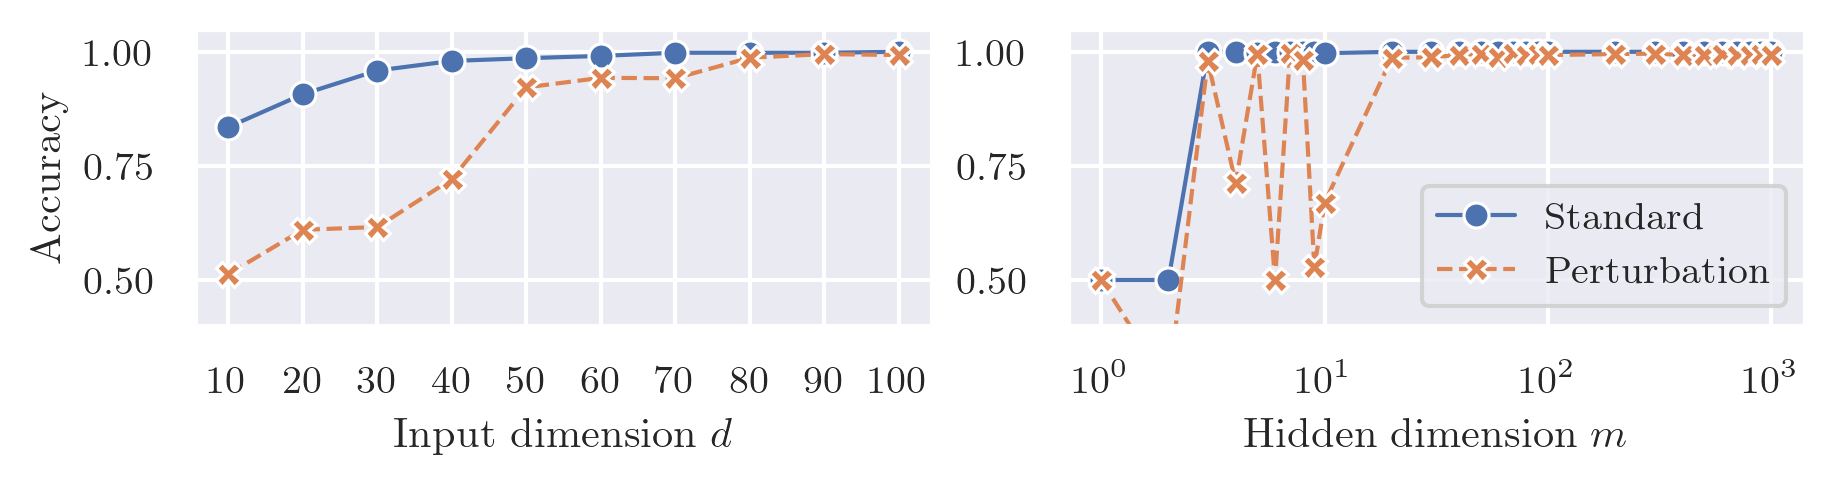

In [7]:
def sG_a_mini() -> None:
    f = begin(1, False)

    kwargs = {
        'in_dim': 100,
        'hidden_dim': 100,
        'slope': 0.,
        'loss_name': 'identity',
        'epochs_1': 1000,
        'epochs_2': 1000,
        'perturbation_size': .01,
        'seed': 0,
        'on_original': False,
        'lrs_1': (1., .1),
        'lrs_2': (1., .1),
        'data_gen_method': 'shifted_gauss',
        'n_sample': 1000,
    }

    result_class = ResultsSyntheticAlongLrs

    in_dims = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    perturbation_sizes = (.0031, .0044, .0054, .0063, .007, .0077, .0083, .0089, .0094, .01)
    embed_graph(f.axes[0][0], result_class, kwargs, ('in_dim', 'perturbation_size'), (in_dims, perturbation_sizes), r'Input dimension $d$', False)
    f.axes[0][0].set_ylabel('Accuracy')

    hidden_dims = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
    embed_graph(f.axes[0][1], result_class, kwargs, ('hidden_dim',), (hidden_dims,), r'Hidden dimension $m$', False)
    f.axes[0][1].set_xlogscale()
    f.axes[0][1].legend()

    end(f, 'shifted_Gauss_a_mini')


sG_a_mini()

### Scenario (b)

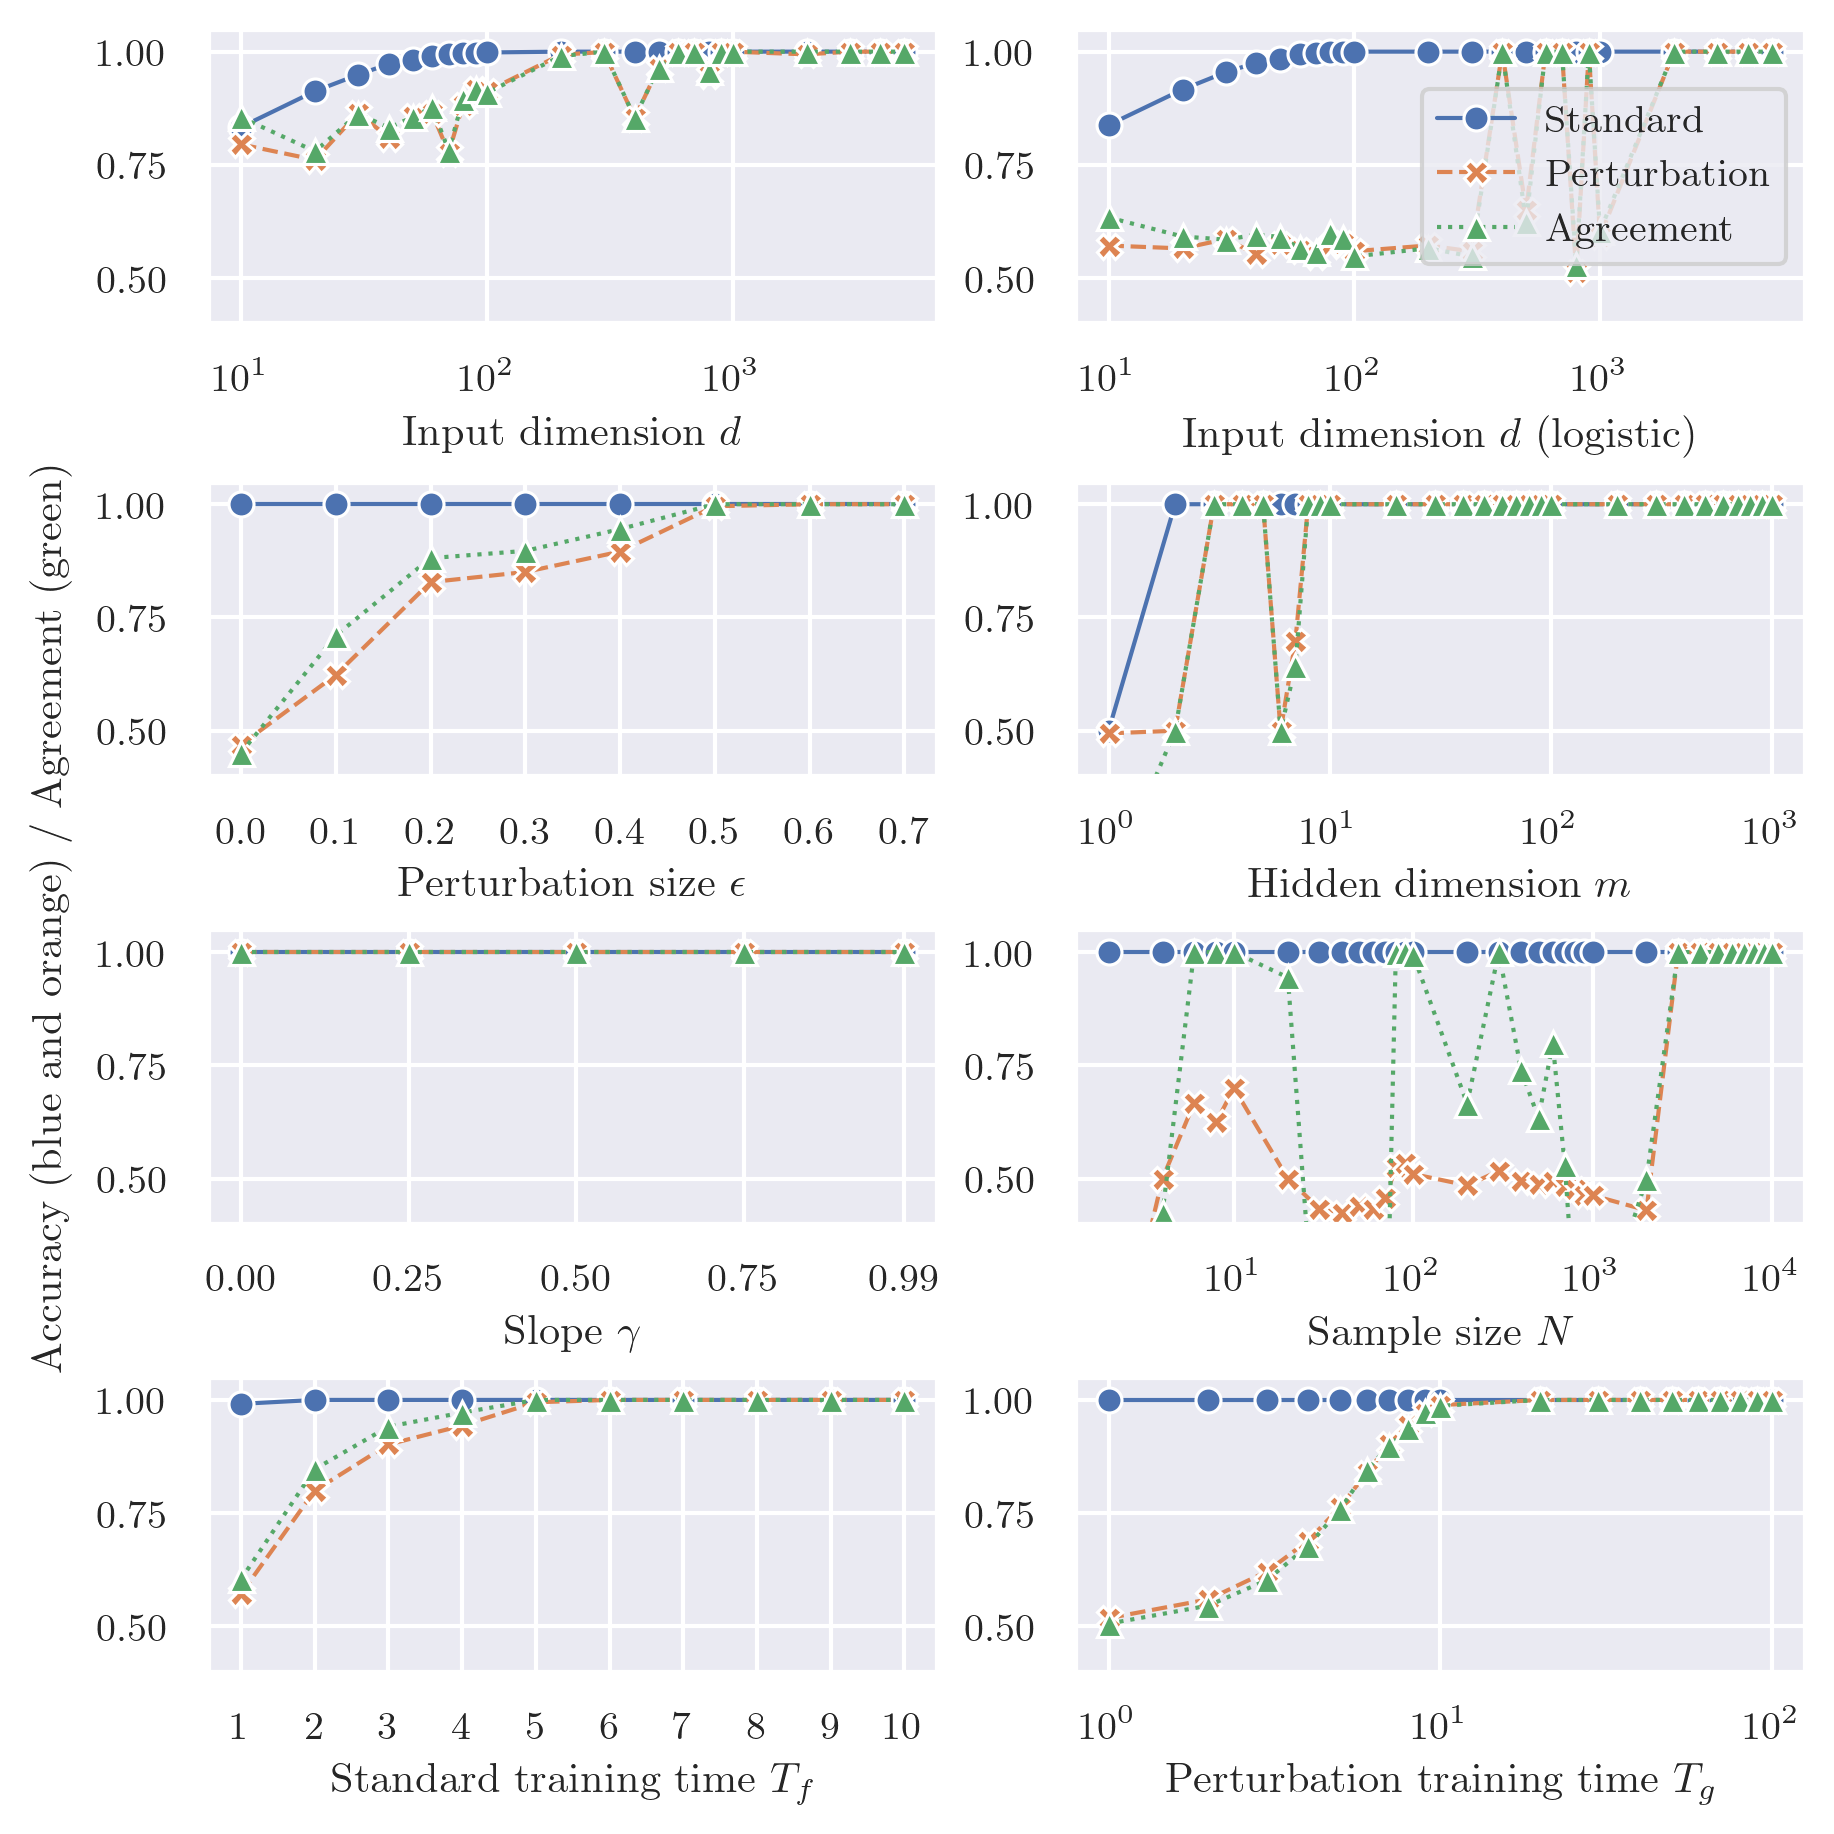

In [8]:
def sG_b() -> None:
    f = begin(4)

    kwargs = {
        'in_dim': 5000,
        'hidden_dim': 100,
        'slope': 0.,
        'loss_name': 'identity',
        'epochs_1': 1000,
        'epochs_2': 1000,
        'perturbation_size': .7,
        'seed': 1,
        'on_original': True,
        'lrs_1': (1., .1),
        'lrs_2': (1., .1),
        'data_gen_method': 'shifted_gauss',
        'n_sample': 10000,
    }

    result_class = ResultsSyntheticAlongLrs

    in_dims = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000)
    perturbation_sizes = (.031, .044, .054, .063, .07, .077, .083, .089, .094, .1, .14, .17, .2, .22, .24, .26, .28, .3, .31, .44, .54, .63, .7)
    embed_graph(f.axes[0][0], result_class, kwargs, ('in_dim', 'perturbation_size'), (in_dims, perturbation_sizes), r'Input dimension $d$')
    f.axes[0][0].set_xlogscale()

    kwargs['loss_name'] = 'logistic'
    kwargs['lrs_1'] = (10., 5., 1., .1, .01)
    kwargs['lrs_2'] = (10., 5., 1., .1, .01)
    embed_graph(f.axes[0][1], result_class, kwargs, ('in_dim', 'perturbation_size'), (in_dims, perturbation_sizes), r'Input dimension $d$ (logistic)')
    f.axes[0][1].set_xlogscale()
    f.axes[0][1].legend()
    kwargs['loss_name'] = 'identity'
    kwargs['lrs_1'] = (1., .1)
    kwargs['lrs_2'] = (1., .1)

    perturbation_sizes = (0., .1, .2, .3, .4, .5, .6, .7)
    embed_graph(f.axes[1][0], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$')

    hidden_dims = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
    embed_graph(f.axes[1][1], result_class, kwargs, ('hidden_dim',), (hidden_dims,), r'Hidden dimension $m$')
    f.axes[1][1].set_xlogscale()

    slopes = (.0, .25, .5, .75, .99)
    embed_graph(f.axes[2][0], result_class, kwargs, ('slope',), (slopes,), r'Slope $\gamma$')

    n_samples = (2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000)
    embed_graph(f.axes[2][1], result_class, kwargs, ('n_sample',), (n_samples,), r'Sample size $N$')
    f.axes[2][1].set_xlogscale()

    kwargs['lrs_1'] = (.01,)
    epochs_1s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
    embed_graph(f.axes[3][0], result_class, kwargs, ('epochs_1',), (epochs_1s,), r'Standard training time $T_f$')
    kwargs['lrs_1'] = (1., .1)

    kwargs['lrs_2'] = (.01,)
    epochs_2s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[3][1], result_class, kwargs, ('epochs_2',), (epochs_2s,), r'Perturbation training time $T_g$')
    f.axes[3][1].set_xlogscale()
    kwargs['lrs_2'] = (1., .1)

    end(f, 'shifted_Gauss_b')


sG_b()

## Gaussian

### Scenario (a)

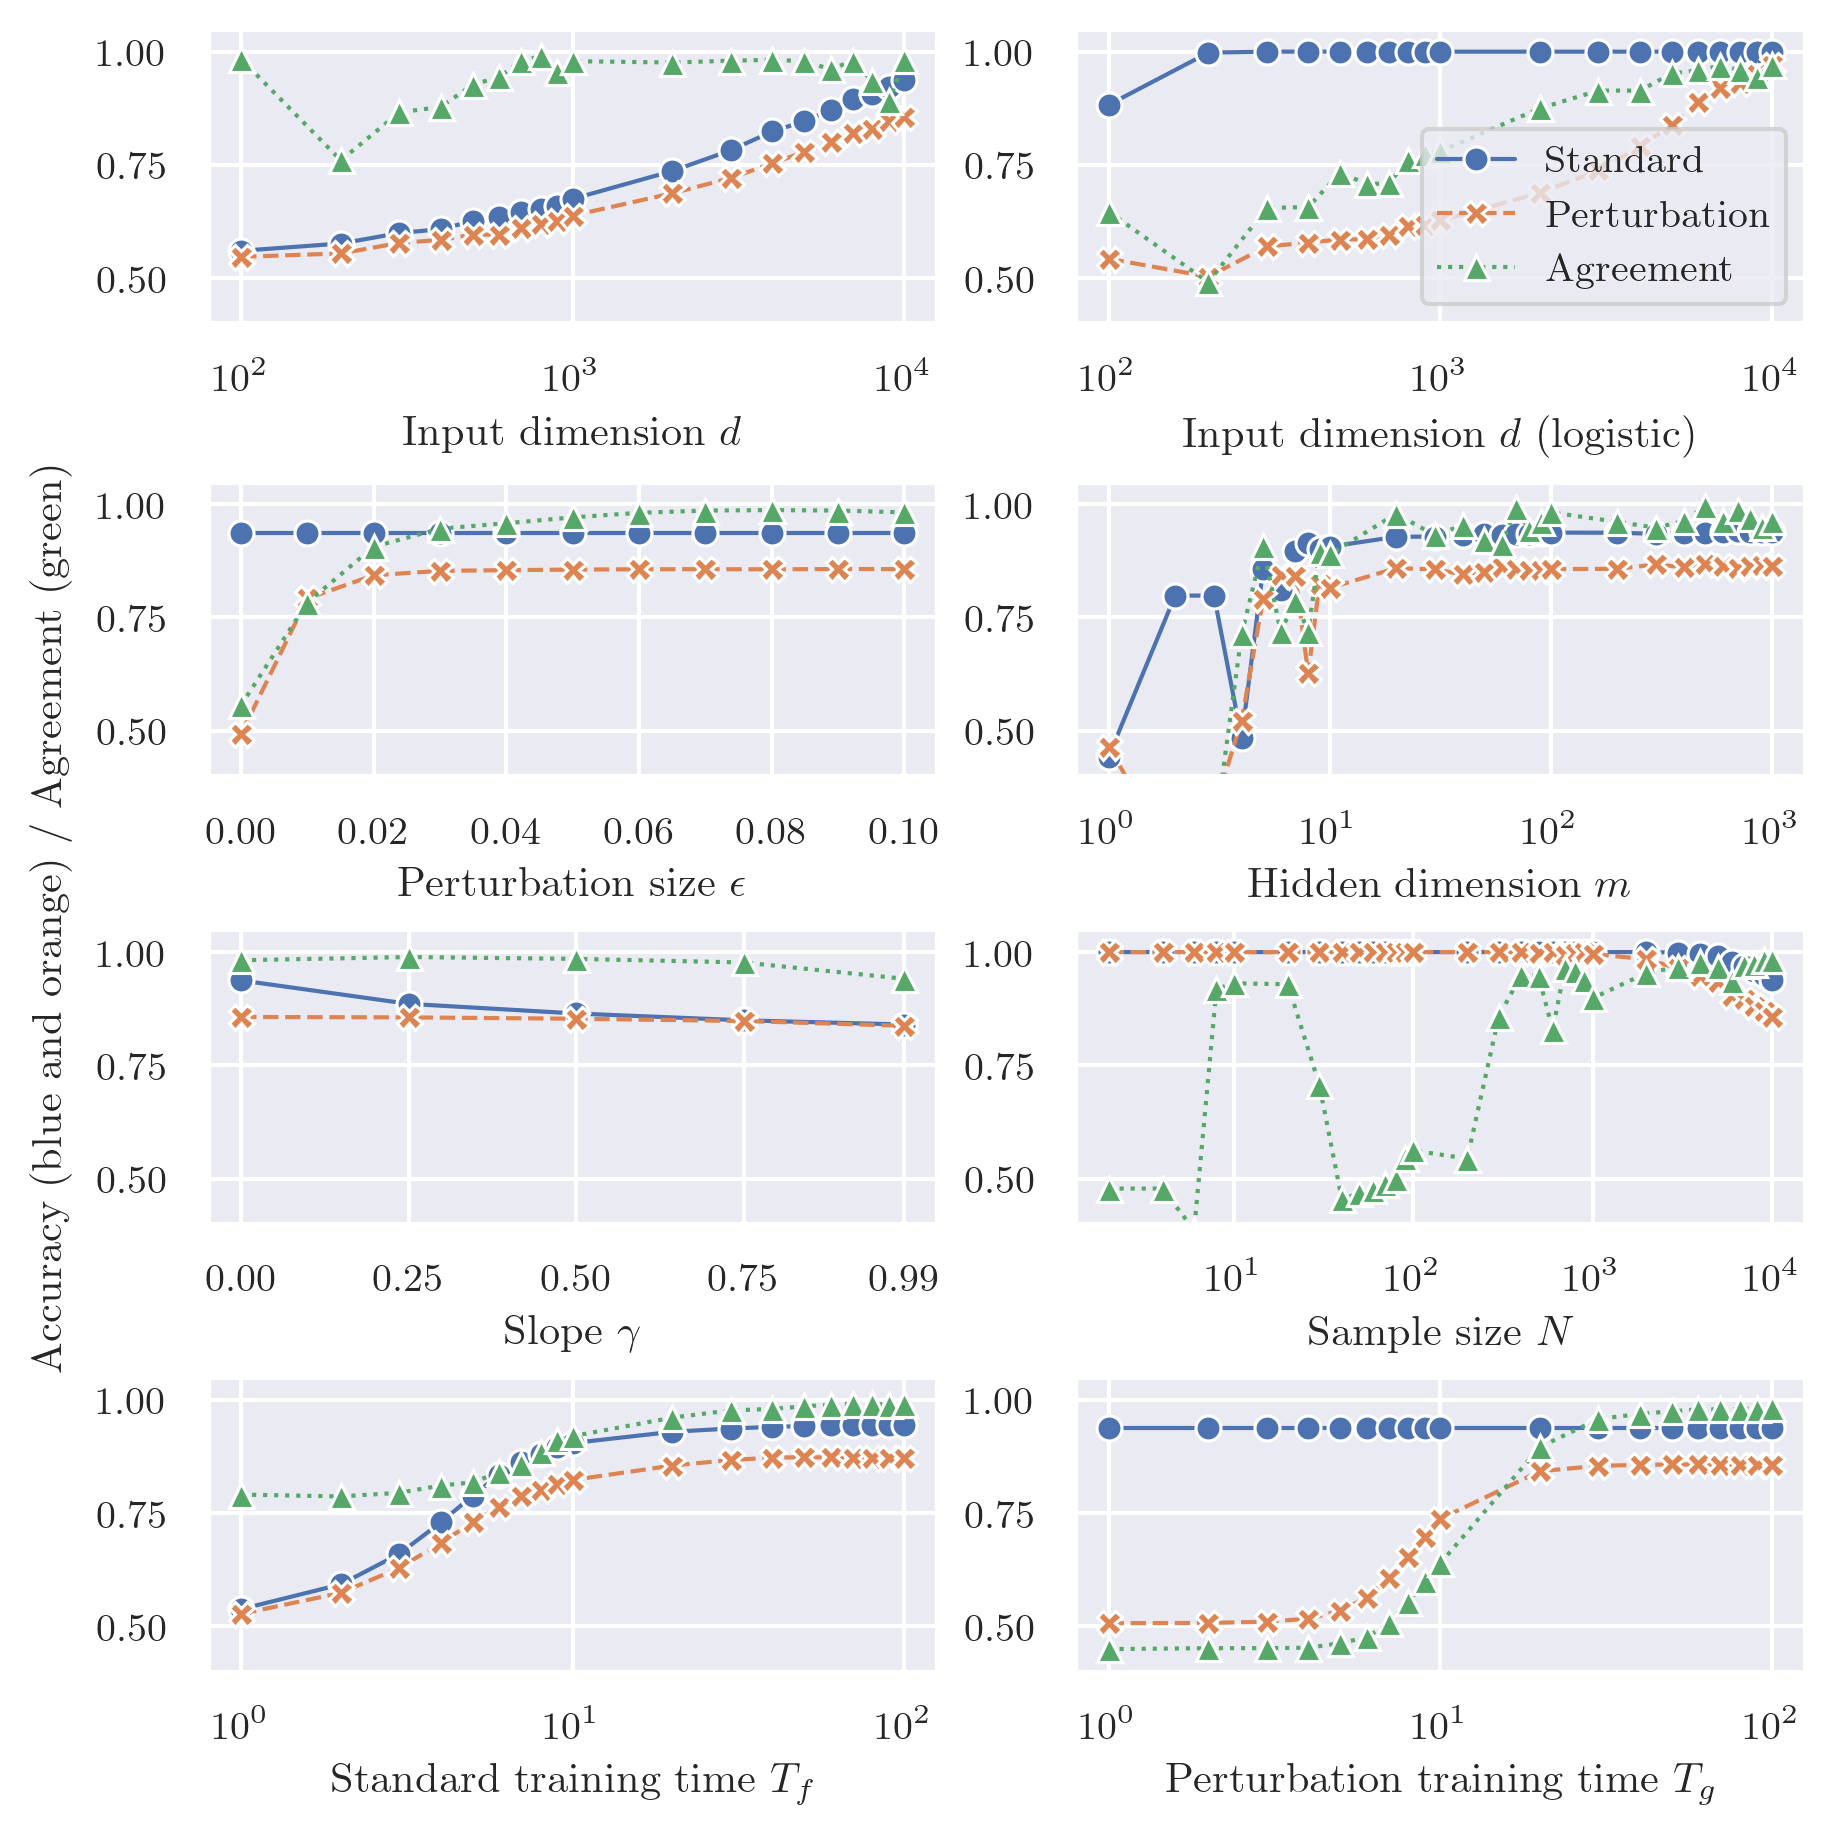

In [9]:
def G_a() -> None:
    f = begin(4)

    kwargs = {
        'in_dim': 10000,
        'hidden_dim': 100,
        'slope': 0.,
        'loss_name': 'identity',
        'epochs_1': 1000,
        'epochs_2': 1000,
        'perturbation_size': .1,
        'seed': 0,
        'on_original': False,
        'lrs_1': (1., .1),
        'lrs_2': (1., .1),
        'data_gen_method': 'gauss',
        'n_sample': 10000,
    }

    result_class = ResultsSyntheticAlongLrs

    in_dims = (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000)
    perturbation_sizes = (.01, .014, .017, .02, .022, .024, .026, .028, .03, .031, .044, .054, .063, .07, .077, .083, .089, .094, .1)
    embed_graph(f.axes[0][0], result_class, kwargs, ('in_dim', 'perturbation_size'), (in_dims, perturbation_sizes), r'Input dimension $d$')
    f.axes[0][0].set_xlogscale()

    kwargs['loss_name'] = 'logistic'
    embed_graph(f.axes[0][1], result_class, kwargs, ('in_dim', 'perturbation_size'), (in_dims, perturbation_sizes), r'Input dimension $d$ (logistic)')
    f.axes[0][1].set_xlogscale()
    f.axes[0][1].legend()
    kwargs['loss_name'] = 'identity'

    perturbation_sizes = (0., .01, .02, .03, .04, .05, .06, .07, .08, .09, .1)
    embed_graph(f.axes[1][0], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$')
    f.axes[1][0].set_xticks((0., .02, .04, .06, .08, .1))

    hidden_dims = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
    embed_graph(f.axes[1][1], result_class, kwargs, ('hidden_dim',), (hidden_dims,), r'Hidden dimension $m$')
    f.axes[1][1].set_xlogscale()

    slopes = (.0, .25, .5, .75, .99)
    embed_graph(f.axes[2][0], result_class, kwargs, ('slope',), (slopes,), r'Slope $\gamma$')

    n_samples = (2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000)
    embed_graph(f.axes[2][1], result_class, kwargs, ('n_sample',), (n_samples,), r'Sample size $N$')
    f.axes[2][1].set_xlogscale()

    kwargs['lrs_1'] = (.1,)
    epochs_1s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[3][0], result_class, kwargs, ('epochs_1',), (epochs_1s,), r'Standard training time $T_f$')
    f.axes[3][0].set_xlogscale()
    kwargs['lrs_1'] = (1., .1)

    epochs_2s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[3][1], result_class, kwargs, ('epochs_2',), (epochs_2s,), r'Perturbation training time $T_g$')
    f.axes[3][1].set_xlogscale()

    end(f, 'Gauss_a')


G_a()

### Scenario (b)

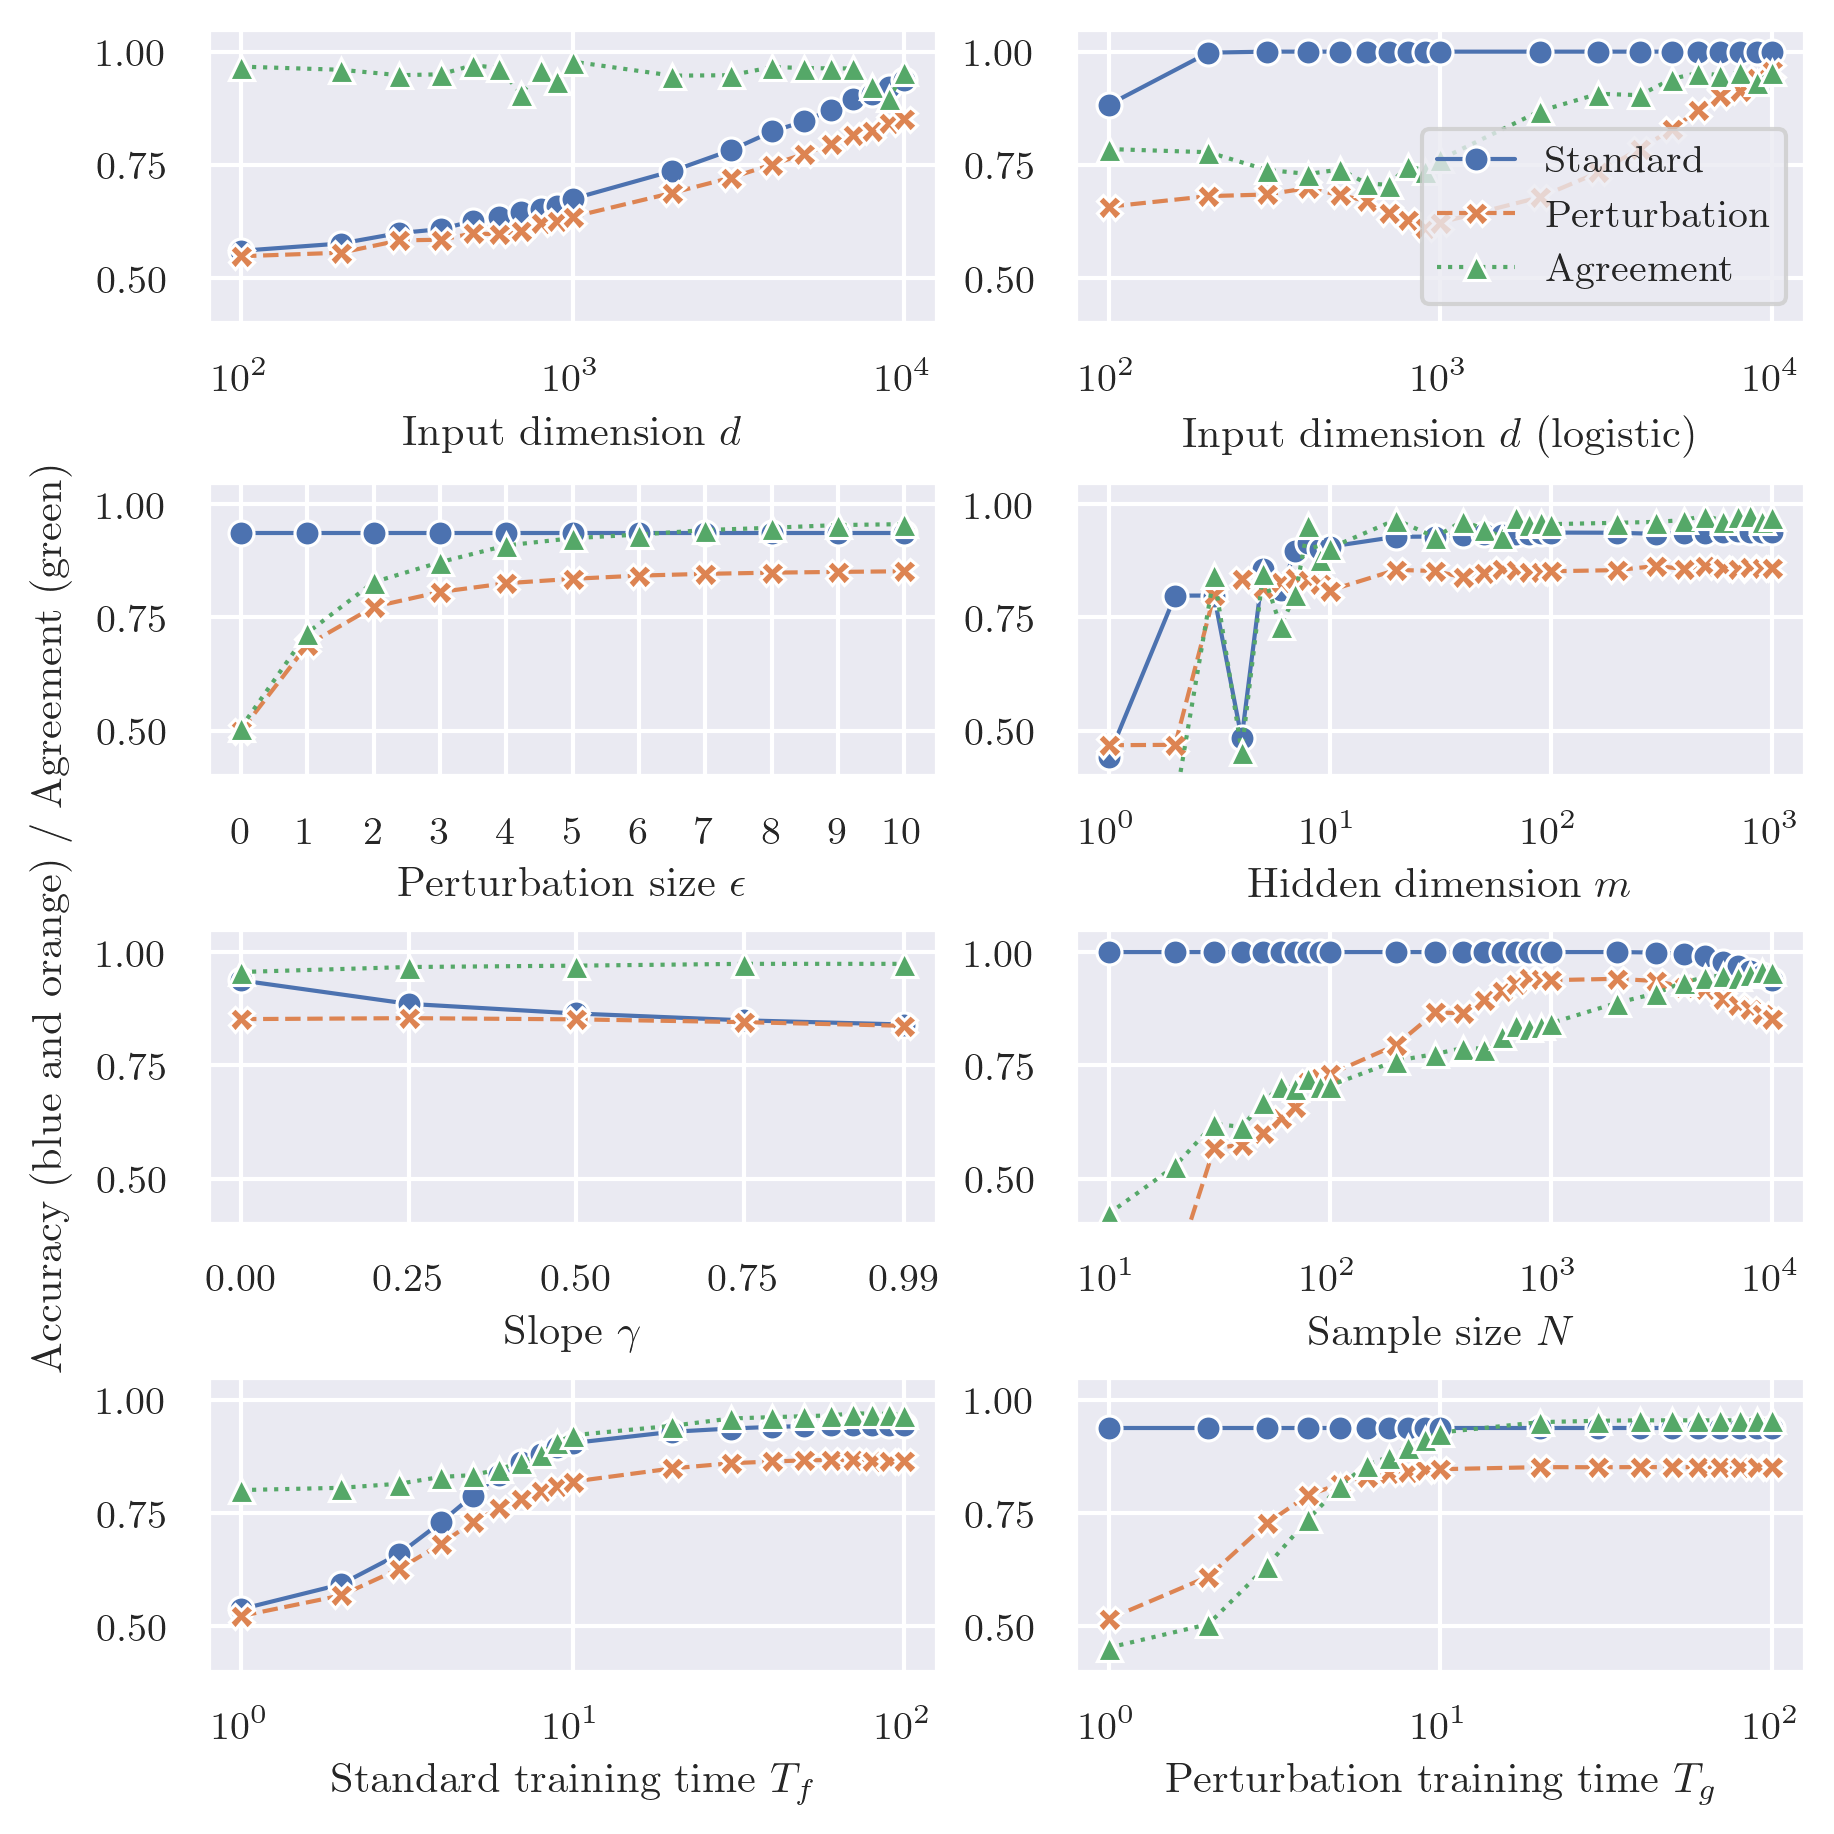

In [10]:
def G_b() -> None:
    f = begin(4)

    kwargs = {
        'in_dim': 10000,
        'hidden_dim': 100,
        'slope': 0.,
        'loss_name': 'identity',
        'epochs_1': 1000,
        'epochs_2': 1000,
        'perturbation_size': 10.,
        'seed': 0,
        'on_original': True,
        'lrs_1': (1., .1),
        'lrs_2': (1., .1),
        'data_gen_method': 'gauss',
        'n_sample': 10000,
    }

    result_class = ResultsSyntheticAlongLrs

    in_dims = (100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000)
    perturbation_sizes = (1., 1.4, 1.7, 2., 2.2, 2.4, 2.6, 2.8, 3., 3.1, 4.4, 5.4, 6.3, 7., 7.7, 8.3, 8.9, 9.4, 10.)
    embed_graph(f.axes[0][0], result_class, kwargs, ('in_dim', 'perturbation_size'), (in_dims, perturbation_sizes), r'Input dimension $d$')
    f.axes[0][0].set_xlogscale()

    kwargs['loss_name'] = 'logistic'
    embed_graph(f.axes[0][1], result_class, kwargs, ('in_dim', 'perturbation_size'), (in_dims, perturbation_sizes), r'Input dimension $d$ (logistic)')
    f.axes[0][1].set_xlogscale()
    f.axes[0][1].legend()
    kwargs['loss_name'] = 'identity'

    perturbation_sizes = (0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.)
    embed_graph(f.axes[1][0], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$')

    hidden_dims = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
    embed_graph(f.axes[1][1], result_class, kwargs, ('hidden_dim',), (hidden_dims,), r'Hidden dimension $m$')
    f.axes[1][1].set_xlogscale()

    slopes = (.0, .25, .5, .75, .99)
    embed_graph(f.axes[2][0], result_class, kwargs, ('slope',), (slopes,), r'Slope $\gamma$')

    n_samples = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000)
    embed_graph(f.axes[2][1], result_class, kwargs, ('n_sample',), (n_samples,), r'Sample size $N$')
    f.axes[2][1].set_xlogscale()

    kwargs['lrs_1'] = (.1,)
    epochs_1s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[3][0], result_class, kwargs, ('epochs_1',), (epochs_1s,), r'Standard training time $T_f$')
    f.axes[3][0].set_xlogscale()
    kwargs['lrs_1'] = (1., .1)

    kwargs['lrs_2'] = (.1,)
    epochs_2s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[3][1], result_class, kwargs, ('epochs_2',), (epochs_2s,), r'Perturbation training time $T_g$')
    f.axes[3][1].set_xlogscale()
    kwargs['lrs_2'] = (1., .1)

    end(f, 'Gauss_b')


G_b()

# Real

## MNIST

### Scenario (a)

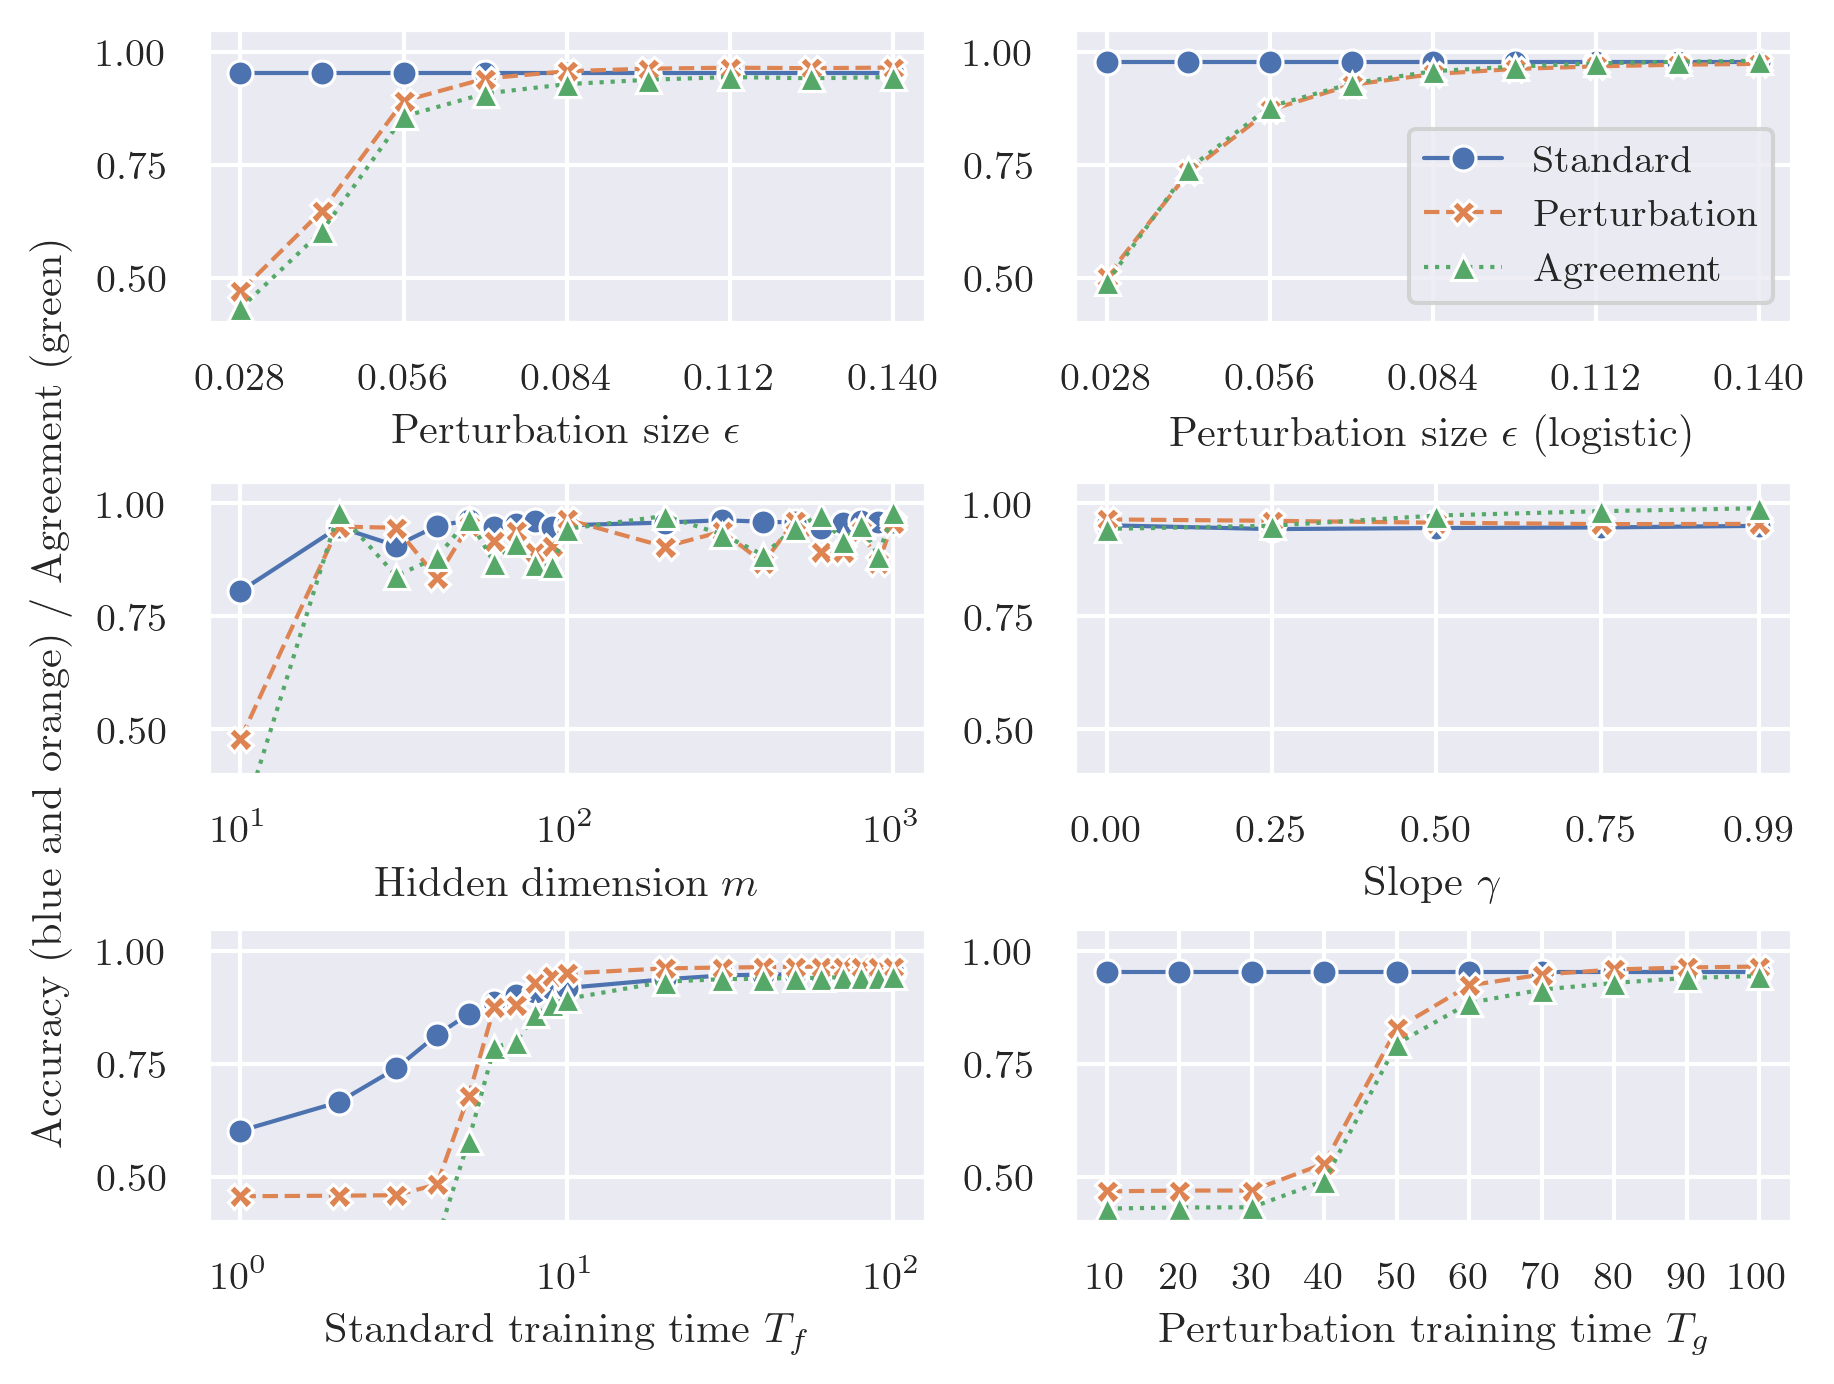

In [11]:
def MNIST_a() -> None:
    f = begin(3)

    kwargs = {
        'hidden_dim': 100,
        'slope': 0.,
        'loss_name': 'identity',
        'epochs_1': 100,
        'epochs_2': 100,
        'perturbation_size': .14,
        'seed': 0,
        'on_original': False,
        'lrs_1': (.01, .001),
        'lrs_2': (.01, .001),
        'dataset_name': 'MNIST',
        'dataset_root': dataset_root,
    }

    result_class = ResultsRealAlongLrs

    perturbation_sizes = (.028, .042, .056, .07, .084, .098, .112, .126, .14)
    embed_graph(f.axes[0][0], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$')
    f.axes[0][0].set_xticks((.028, .056, .084, .112, .14))

    kwargs['loss_name'] = 'logistic'
    embed_graph(f.axes[0][1], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$ (logistic)')
    f.axes[0][1].set_xticks((.028, .056, .084, .112, .14))
    f.axes[0][1].legend()
    kwargs['loss_name'] = 'identity'

    hidden_dims = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
    embed_graph(f.axes[1][0], result_class, kwargs, ('hidden_dim',), (hidden_dims,), r'Hidden dimension $m$')
    f.axes[1][0].set_xlogscale()

    slopes = (0., .25, .5, .75, .99)
    embed_graph(f.axes[1][1], result_class, kwargs, ('slope',), (slopes,), r'Slope $\gamma$')

    epochs_1s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[2][0], result_class, kwargs, ('epochs_1',), (epochs_1s,), r'Standard training time $T_f$')
    f.axes[2][0].set_xlogscale()

    epochs_2s = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[2][1], result_class, kwargs, ('epochs_2',), (epochs_2s,), r'Perturbation training time $T_g$')

    end(f, 'MNIST_a')


MNIST_a()

### Scenario (b)

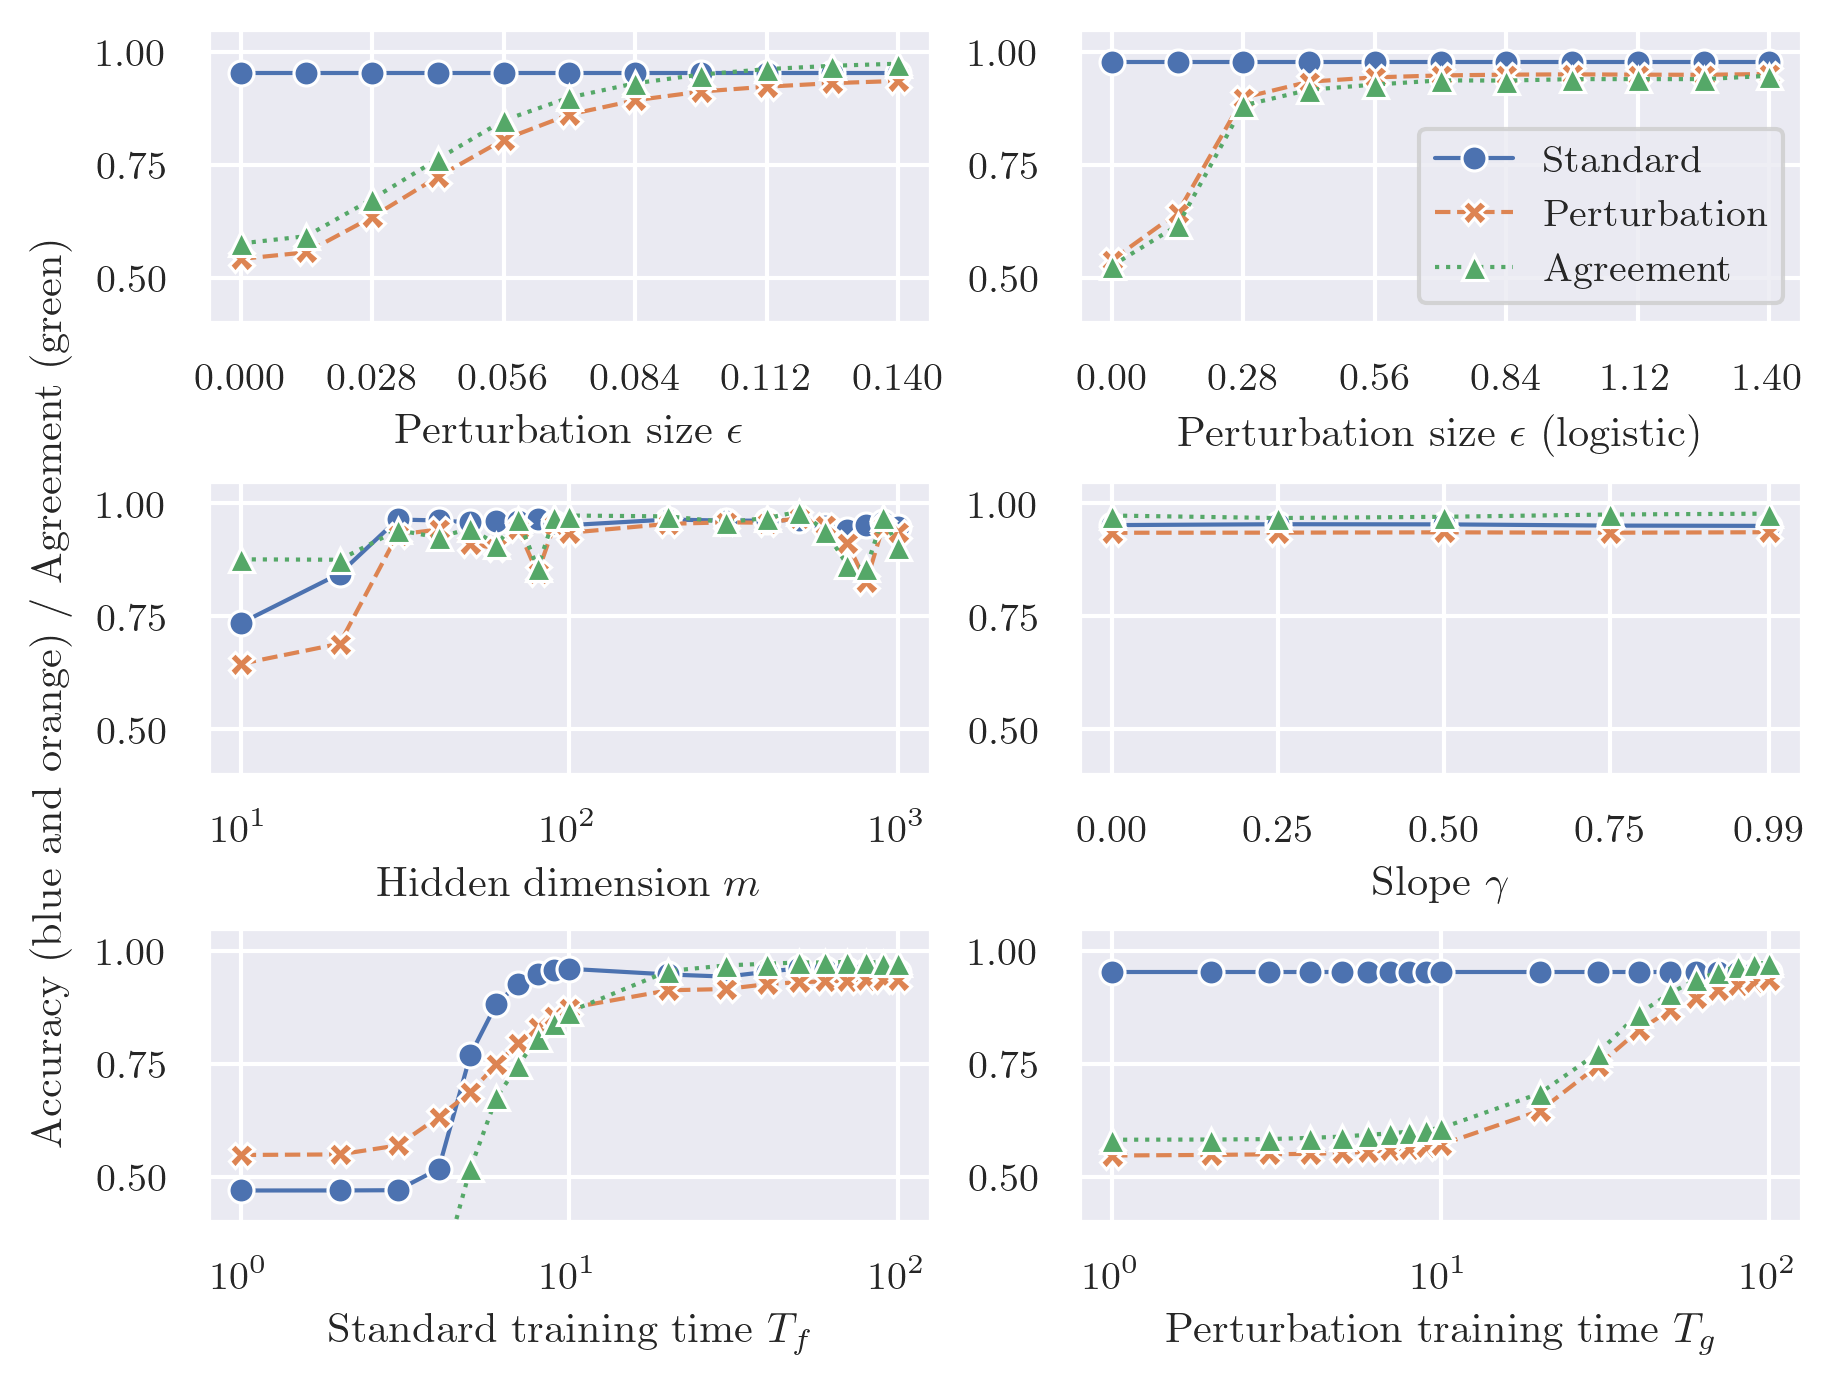

In [12]:
def MNIST_b() -> None:
    f = begin(3)

    kwargs = {
        'hidden_dim': 100,
        'slope': 0.,
        'loss_name': 'identity',
        'epochs_1': 100,
        'epochs_2': 100,
        'perturbation_size': .14,
        'seed': 1,
        'on_original': True,
        'lrs_1': (.01, .001),
        'lrs_2': (.01, .001),
        'dataset_name': 'MNIST',
        'dataset_root': dataset_root,
    }

    result_class = ResultsRealAlongLrs

    perturbation_sizes = (0., .014, .028, .042, .056, .07, .084, .098, .112, .126, .14)
    embed_graph(f.axes[0][0], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$')
    f.axes[0][0].set_xticks((0, .028, .056, .084, .112, .14))

    kwargs['loss_name'] = 'logistic'
    kwargs['seed'] = 2
    perturbation_sizes = (0., .14, .28, .42, .56, .7, .84, .98, 1.12, 1.26, 1.4)
    embed_graph(f.axes[0][1], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$ (logistic)')
    f.axes[0][1].set_xticks((0, .28, .56, .84, 1.12, 1.4))
    f.axes[0][1].legend()
    kwargs['loss_name'] = 'identity'
    kwargs['seed'] = 1

    hidden_dims = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
    embed_graph(f.axes[1][0], result_class, kwargs, ('hidden_dim',), (hidden_dims,), r'Hidden dimension $m$')
    f.axes[1][0].set_xlogscale()

    slopes = (0., .25, .5, .75, .99)
    embed_graph(f.axes[1][1], result_class, kwargs, ('slope',), (slopes,), r'Slope $\gamma$')

    epochs_1s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[2][0], result_class, kwargs, ('epochs_1',), (epochs_1s,), r'Standard training time $T_f$')
    f.axes[2][0].set_xlogscale()

    epochs_2s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[2][1], result_class, kwargs, ('epochs_2',), (epochs_2s,), r'Perturbation training time $T_g$')
    f.axes[2][1].set_xlogscale()

    end(f, 'MNIST_b')


MNIST_b()

## FMNIST

### Scenario (a)

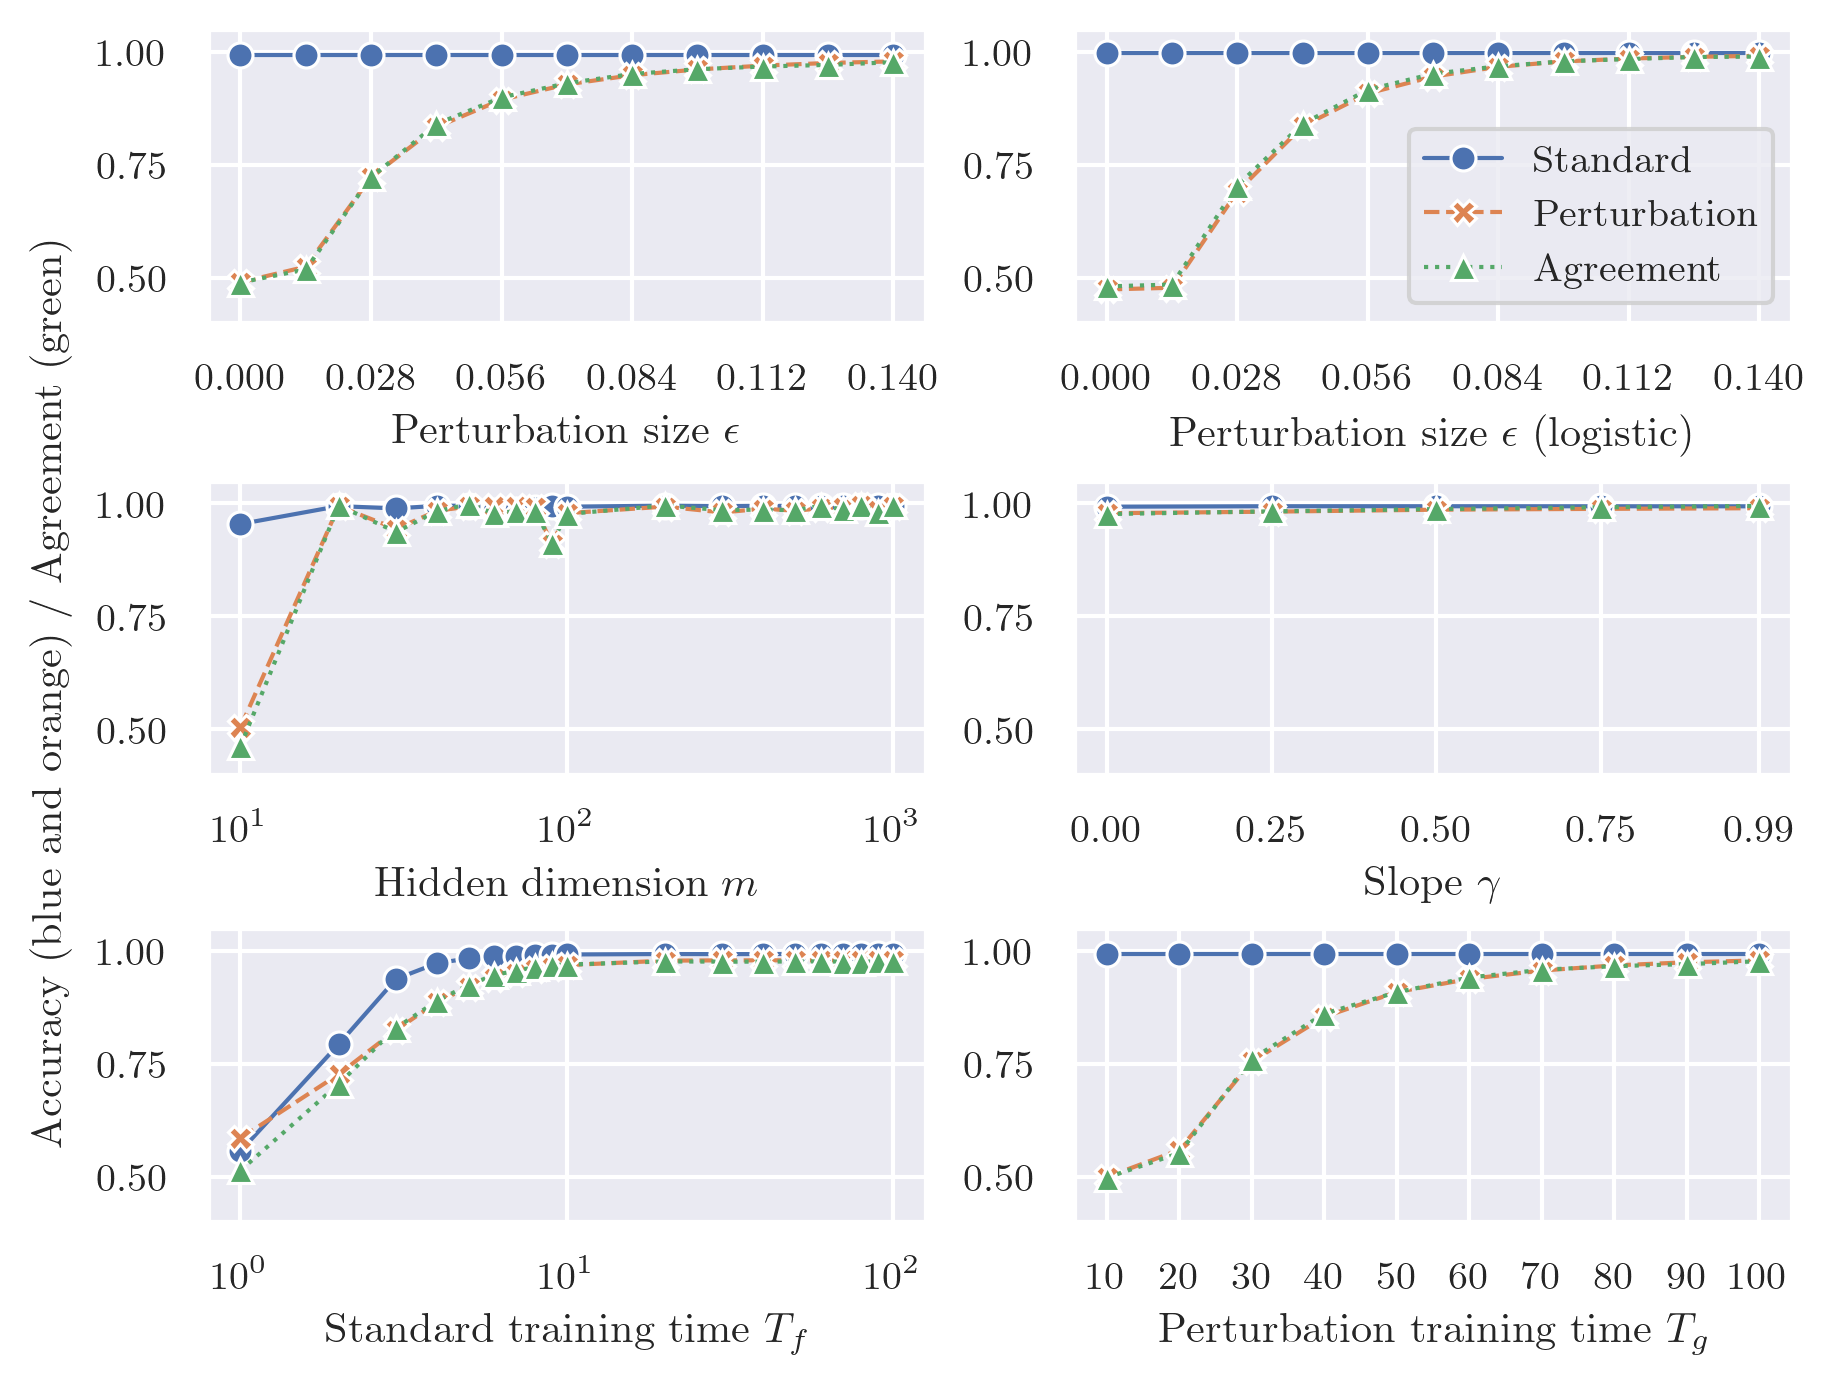

In [13]:
def FMNIST_a() -> None:
    f = begin(3)

    kwargs = {
        'hidden_dim': 100,
        'slope': 0.,
        'loss_name': 'identity',
        'epochs_1': 100,
        'epochs_2': 100,
        'perturbation_size': .14,
        'seed': 0,
        'on_original': False,
        'lrs_1': (.01, .001),
        'lrs_2': (.01, .001),
        'dataset_name': 'FMNIST',
        'dataset_root': dataset_root,
    }

    result_class = ResultsRealAlongLrs

    perturbation_sizes = (0., .014, .028, .042, .056, .07, .084, .098, .112, .126, .14)
    embed_graph(f.axes[0][0], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$')
    f.axes[0][0].set_xticks((0, .028, .056, .084, .112, .14))

    kwargs['loss_name'] = 'logistic'
    embed_graph(f.axes[0][1], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$ (logistic)')
    f.axes[0][1].set_xticks((0, .028, .056, .084, .112, .14))
    f.axes[0][1].legend()
    kwargs['loss_name'] = 'identity'

    hidden_dims = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
    embed_graph(f.axes[1][0], result_class, kwargs, ('hidden_dim',), (hidden_dims,), r'Hidden dimension $m$')
    f.axes[1][0].set_xlogscale()

    slopes = (.0, .25, .5, .75, .99)
    embed_graph(f.axes[1][1], result_class, kwargs, ('slope',), (slopes,), r'Slope $\gamma$')

    epochs_1s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[2][0], result_class, kwargs, ('epochs_1',), (epochs_1s,), r'Standard training time $T_f$')
    f.axes[2][0].set_xlogscale()

    epochs_2s = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[2][1], result_class, kwargs, ('epochs_2',), (epochs_2s,), r'Perturbation training time $T_g$')

    end(f, 'FMNIST_a')


FMNIST_a()

### Scenario (b)

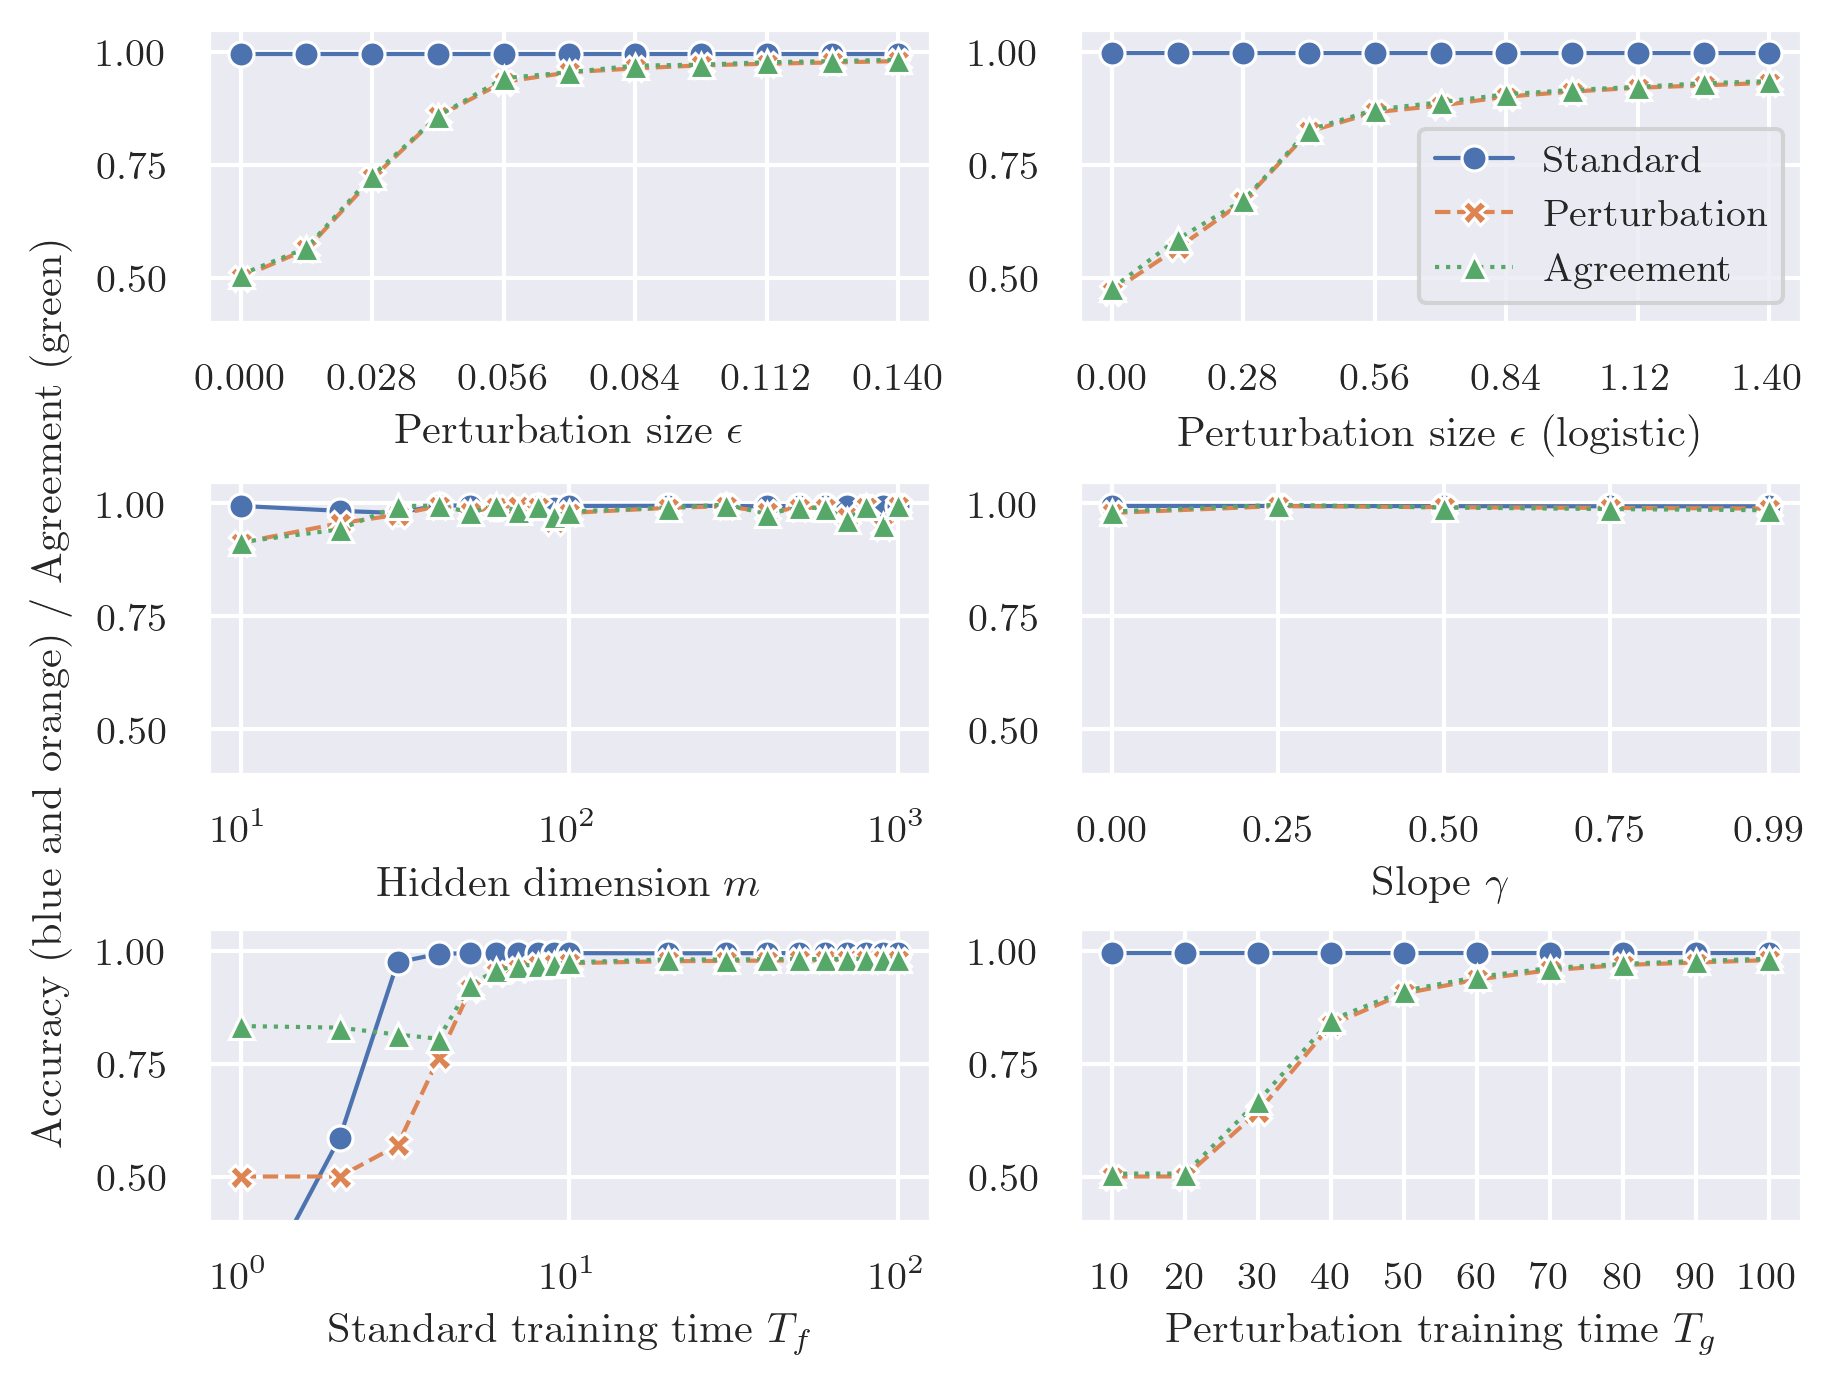

In [14]:
def FMNIST_b() -> None:
    f = begin(3)

    kwargs = {
        'hidden_dim': 100,
        'slope': 0.,
        'loss_name': 'identity',
        'epochs_1': 100,
        'epochs_2': 100,
        'perturbation_size': .14,
        'seed': 2,
        'on_original': True,
        'lrs_1': (.01, .001),
        'lrs_2': (.01, .001),
        'dataset_name': 'FMNIST',
        'dataset_root': dataset_root,
    }

    result_class = ResultsRealAlongLrs

    perturbation_sizes = (0., .014, .028, .042, .056, .07, .084, .098, .112, .126, .14)
    embed_graph(f.axes[0][0], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$')
    f.axes[0][0].set_xticks((0., .028, .056, .084, .112, .14))

    kwargs['loss_name'] = 'logistic'
    perturbation_sizes = (0., .14, .28, .42, .56, .7, .84, .98, 1.12, 1.26, 1.4)
    embed_graph(f.axes[0][1], result_class, kwargs, ('perturbation_size',), (perturbation_sizes,), r'Perturbation size $\epsilon$ (logistic)')
    f.axes[0][1].set_xticks((0, .28, .56, .84, 1.12, 1.4))
    f.axes[0][1].legend()
    kwargs['loss_name'] = 'identity'

    hidden_dims = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000)
    embed_graph(f.axes[1][0], result_class, kwargs, ('hidden_dim',), (hidden_dims,), r'Hidden dimension $m$')
    f.axes[1][0].set_xlogscale()

    slopes = (.0, .25, .5, .75, .99)
    embed_graph(f.axes[1][1], result_class, kwargs, ('slope',), (slopes,), r'Slope $\gamma$')

    epochs_1s = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[2][0], result_class, kwargs, ('epochs_1',), (epochs_1s,), r'Standard training time $T_f$')
    f.axes[2][0].set_xlogscale()

    epochs_2s = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
    embed_graph(f.axes[2][1], result_class, kwargs, ('epochs_2',), (epochs_2s,), r'Perturbation training time $T_g$')

    end(f, 'FMNIST_b')


FMNIST_b()